In [1]:
%load_ext autoreload
%autoreload 2

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../ipa/src')
import gaussmle as mle
import pandas as pd
import nd2
import localization_utils as loc
import preprocessing_utils as pre
from skimage.morphology import extrema
import detection_utils as det

# import detections

In [120]:
df = pd.read_csv('/tungstenfs/scratch/ggiorget/nessim/2_color_imaging/localization_precision_estimation/runs/20240425_beads/detections_20240425_B2_100ms_7%laser_nd.nd2.csv')

In [121]:
im = nd2.imread('/tungstenfs/scratch/ggiorget/nessim/microscopy_data/20240425/beads/ND_Acquisition/20240425_B2_100ms_7%laser_nd.nd2')

In [122]:
im.shape

(21, 4, 976, 976)

In [123]:
df.x = df.x/ 0.130
df.y = df.y/ 0.130
df.z = df.z/ 0.2

In [124]:
df['x_pixels'] = df['x'].astype(int)
df['y_pixels'] = df['y'].astype(int)
df['z_pixels'] = df['z'].astype(int)

In [125]:
df_detections = df[['x_pixels', 'y_pixels', 'z_pixels', 'frame']]

In [126]:
EPS = 1e-4

In [127]:
df_detections.x_pixels.values[0]

158

In [128]:
im.shape

(21, 4, 976, 976)

In [129]:
im_max = np.max(im, axis=0)

(0.0, 200.0)

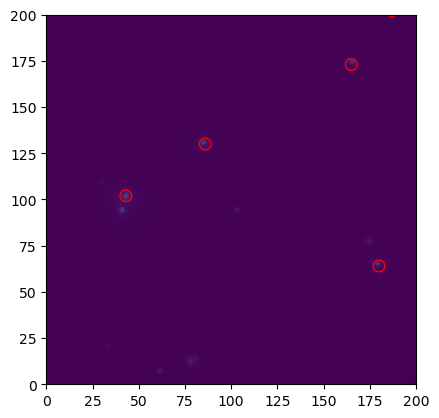

In [130]:
plt.imshow(im_max[2,...])
plt.scatter(df_detections.x_pixels, df_detections.y_pixels, facecolors='none',edgecolors='r', s=70)
plt.xlim(0,200)
plt.ylim(0,200)

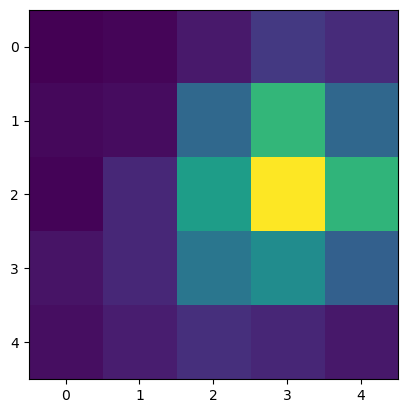

In [240]:
c = 4
crop,start_dim1, end_dim1, start_dim2, end_dim2 = loc.get_crop(df_detections.y_pixels.values[c],df_detections.x_pixels.values[c], 5,im_max[1,...])
plt.imshow(crop)

In [241]:
crops = np.expand_dims(crop, axis=0)

In [247]:
thetas, CRLBs, likelihoods, iterations = mle.gaussmle(crops,EPS,2)

-4.2109375
-6.14501953125
-6.99365234375
-10.15576171875
-13.7919921875
-13.84228515625
-23.5751953125
-23.6240234375
-23.8603515625
-53.0068359375
-55.158203125
-55.3447265625
-55.6181640625
-78.8310546875
-87.7216796875
-93.7236328125
-107.74853515625
-131.84521484375
-165.39404296875
-188.11083984375
-189.984375
-209.96240234375
-236.62841796875
-237.02099609375
-238.611328125
Spot 0 iterations: 4 LogLikelihood: -238.611328125 theta: [1.9517142e+00 3.1061654e+00 2.1805301e+04 8.3716516e+02 8.7622702e-01]


In [206]:
thetas

array([[2.0907907e+00, 3.3682127e+00, 4.0994797e+04, 1.1810542e+03,
        8.5222048e-01, 8.5222048e-01]], dtype=float32)

In [207]:
box = 11

y = thetas[:, 0] + start_dim1
x = thetas[:, 1] + start_dim2

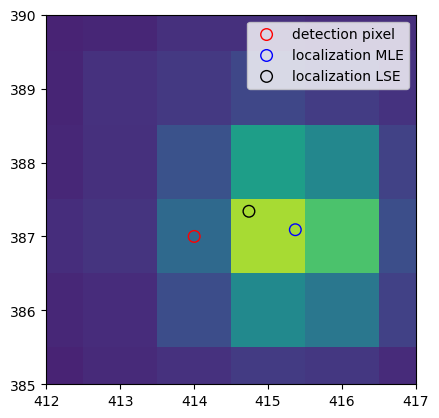

In [208]:
plt.imshow(im_max[1,...],vmin=0,vmax=10000)
plt.scatter(df_detections.x_pixels.values[c], df_detections.y_pixels.values[c], facecolors='none',edgecolors='r', s=70,label='detection pixel')
plt.scatter(x, y, facecolors='none',edgecolors='blue', s=70, label='localization MLE')
plt.scatter(df.x,df.y, facecolors='none',edgecolors='black', s=70, label= 'localization LSE')
plt.ylim(start_dim1,end_dim1)
plt.xlim(start_dim2,end_dim2)
plt.legend()

In [152]:
crops,start_dim1, end_dim1, start_dim2, end_dim2 = zip(*map(loc.get_crop, df_detections.y_pixels.values, df_detections.x_pixels.values, [11]*len(df_detections), [im_max[1,...]]*len(df_detections)))

In [155]:
thetas, CRLBs, likelihoods, iterations = mle.gaussmle(crops,EPS,2)

In [156]:
y = thetas[:, 0] + start_dim1
x = thetas[:, 1] + start_dim2

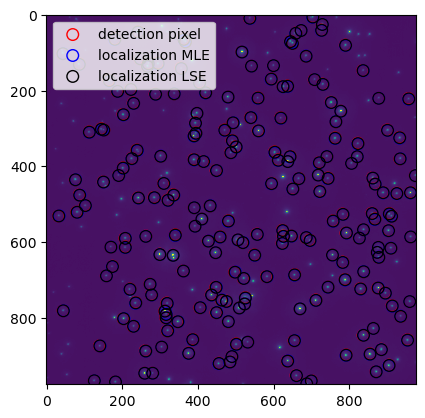

In [161]:
plt.imshow(im_max[1,...],vmin=0,vmax=10000)
plt.scatter(df_detections.x_pixels.values, df_detections.y_pixels.values, facecolors='none',edgecolors='r', s=70,label='detection pixel')
plt.scatter(x, y, facecolors='none',edgecolors='blue', s=70, label='localization MLE')
plt.scatter(df.x,df.y, facecolors='none',edgecolors='black', s=70, label= 'localization LSE')

plt.legend()

In [174]:
from scipy.spatial import distance_matrix

def assign_closest(df1,df2,cutoff):
    d = distance_matrix(df1[['x','y']].values,df2[['x','y']].values)
    matched = []

    for i in range(len(d)):
        # loop over the rows of the matrix
        index = np.argsort(d[i]) # sort the row by distance (closest first)
        sort = d[i][index] # sorted distances
        for j in range(len(sort)): # loop over distances
            if sort[j] > cutoff: # if the distance is greater than the cutoff, break the loop
                break
            else:
                d_col = d[:,index[j]] # get the column of the distance matrix (corresponding to the closest spot in the other channel)
                if np.min(d_col) < sort[j]:# no match
                    pass
                else:
                    distance_vector=df1[['x','y']].values[i] - df2[['x','y']].values[index[j]]
                    matched.append((i,index[j],distance_vector[0],distance_vector[1]))
    return matched

In [175]:
df2 = pd.DataFrame({'x':x,'y':y})


In [176]:
match = assign_closest(df,df2,1)

In [178]:
len(match)

196

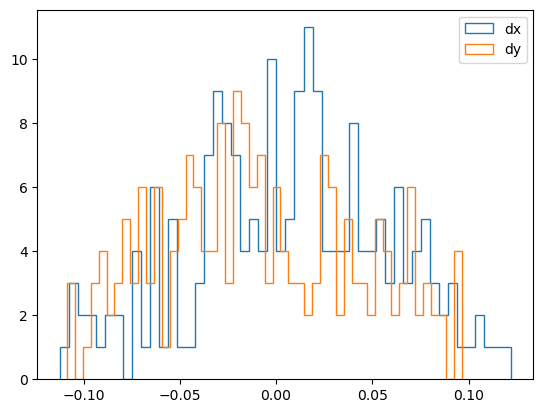

In [185]:
plt.hist([m[2]*0.130 for m in match], bins=50,histtype='step',label='dx')
plt.hist([m[3]*0.130 for m in match], bins=50,histtype='step',label='dy')
plt.legend()
plt.show()

# Test with detection

In [211]:
im.shape

(21, 4, 976, 976)

In [212]:
im_c1 = im[:,1,...]

In [218]:
h = pre.compute_h_param(im=np.expand_dims(np.max(im_c1,axis=0),axis=0),frame=0,mins = 1.974 ,maxs= 3.0 ,thresh= 0.6)
print(h)

/tungstenfs/scratch/ggiorget/nessim/miniconda3/envs/cohesin_multiprocess/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tungstenfs/scratch/ggiorget/nessim/miniconda3/envs/cohesin_multiprocess/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


923.4919945752323


In [235]:
im_mask = extrema.h_maxima(np.max(im_c1,axis=0),h=int(h))
y,x = np.nonzero(im_mask)
print(len(x))
array = np.array([y,x]).T
array = set([tuple(i) for i in array])
y,x = zip(*array)
crop_size=4
max_iter = 2

print('here')
crops,start_dim1, end_dim1, start_dim2, end_dim2 = zip(*map(loc.get_crop, y, x, [crop_size]*len(x), [np.max(im_c1,axis=0)]*len(df_detections)))
print('MLE')
thetas, CRLBs, likelihoods, iterations = mle.gaussmle(crops,EPS,max_iter)

y = thetas[:, 0] + start_dim1
x = thetas[:, 1] + start_dim2

295
here
MLE


In [236]:
det_gauss = det.hmax_detection_fast(raw_im=np.expand_dims(np.max(im_c1,axis=0),axis=0),frame=0,sd=h,n=1,thresh = 0.5,threads=5)

295


In [237]:
len(x)

215

In [238]:
len(det_gauss)

293

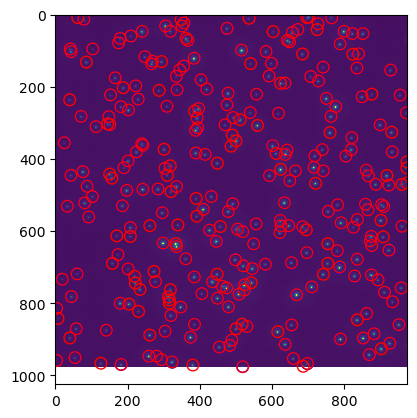

In [234]:
plt.imshow(np.max(im_c1,axis=0),vmin=0,vmax=10000)
plt.scatter(x, y, facecolors='none',edgecolors='blue', s=70, label='localization MLE')
plt.scatter(det_gauss.y, det_gauss.x ,facecolors='none',edgecolors='red', s=70, label='detection')